# Santander - Customer Satisfaction

In [225]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib notebook
import seaborn as sns

# sklearn imports 
import sklearn.feature_selection as fs
import sklearn.ensemble as ee
import sklearn.model_selection as ms
import sklearn.metrics as m

# other libraries 
import pandas_ml
import xgboost as xgb
from mlxtend.evaluate import confusion_matrix 
from mlxtend.plotting import plot_confusion_matrix

In [2]:
# read in the data 

df = pd.read_csv("Data/train.csv")

In [3]:
# Find out the class balance 

df["TARGET"].value_counts() 

0    73012
1     3008
Name: TARGET, dtype: int64

In [4]:
# number of columns 

len(df.columns)

371

In [5]:
df.columns 

Index(['ID', 'var3', 'var15', 'imp_ent_var16_ult1', 'imp_op_var39_comer_ult1',
       'imp_op_var39_comer_ult3', 'imp_op_var40_comer_ult1',
       'imp_op_var40_comer_ult3', 'imp_op_var40_efect_ult1',
       'imp_op_var40_efect_ult3',
       ...
       'saldo_medio_var33_hace2', 'saldo_medio_var33_hace3',
       'saldo_medio_var33_ult1', 'saldo_medio_var33_ult3',
       'saldo_medio_var44_hace2', 'saldo_medio_var44_hace3',
       'saldo_medio_var44_ult1', 'saldo_medio_var44_ult3', 'var38', 'TARGET'],
      dtype='object', length=371)

In [6]:
# double check for categorical variables 
num_cols = df._get_numeric_data().columns
cat_cols = list(set(df.columns) - set(num_cols))
cat_cols

[]

In [7]:
# extract the target variable
target = df["TARGET"]

#  Data Processing 

In [8]:
# remove no variance
no_variance = fs.VarianceThreshold()

# fit_transform to get the columns with no variance 
results = no_variance.fit_transform(df)

# get the columns mask
columns_to_select = no_variance.get_support()

In [9]:
# use the mask boolean to get the feature names
# 34 columns dropped at this stage
columns_selected = []

for a,b in zip(columns_to_select, df.columns):
    if a == True:
        columns_selected.append(b)
        
new_df = df[columns_selected]
len(df.columns) - len(columns_selected)

34

In [10]:
# check for missing values 
# no missing values but quite a few of zeros in numercial columns
# with more information not sure if 0 is a default occurence or 

null_results = new_df.isnull().any()
null_results[null_results != False]

Series([], dtype: bool)

# Feature Selection

In [11]:
# select the training data set 

training_data = new_df.drop(["ID","TARGET"], axis=1)

In [12]:
# check information gain, by using a random forest classifier

clf = ee.RandomForestClassifier()
clf.fit(training_data,target)

info_gain = clf.feature_importances_

C:\Users\farthur\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [13]:
# transfer the info gain results into a dataframe 
df_info = pd.DataFrame(training_data.columns.tolist())
df_info.columns = ['Features']
df_info["Info_Gain"] = info_gain

In [14]:
# sort the info gain values in decending order
df_info.sort_values(by=["Info_Gain"], ascending=False, inplace=True)

# store the results of the dataframe
try:
    df_info.to_csv("feature_importance1.csv")
except: 
    pass

In [70]:
def drop_dup_cols(dataset):
    colsToRemove = []
    columns = dataset.columns
    for col_idx in range(dataset.shape[1]-1):
        col_arr1=dataset[columns[col_idx]].values
        for col_idx2 in range(col_idx+1,dataset.shape[1]):
            col_arr2=dataset[columns[col_idx2]].values
            if np.array_equal(col_arr1,col_arr2):
                colsToRemove.append(columns[col_idx2])
    colsToRemove=list(set(colsToRemove))
    return colsToRemove

cols_to_remove = drop_dup_cols(new_df)

In [78]:
# Duplicated columns have low values of info_gain and won't get picked up
for i in cols_to_remove:
    print(df_info[df_info["Features"] == i])
    print("\n")

     Features  Info_Gain
66  ind_var34        0.0


     Features  Info_Gain
51  ind_var26   0.000128


                      Features  Info_Gain
194  delta_num_reemb_var33_1y3        0.0


      Features  Info_Gain
129  num_var32   0.000099


                         Features  Info_Gain
316  saldo_medio_var13_medio_ult1        0.0


     Features  Info_Gain
74  ind_var39        0.0


      Features  Info_Gain
101  num_var18        0.0


     Features  Info_Gain
55  ind_var29        0.0


        Features  Info_Gain
122  num_var29_0        0.0


     Features  Info_Gain
42  ind_var18        0.0


      Features  Info_Gain
109  num_var25   0.000491


        Features  Info_Gain
163  saldo_var29        0.0


                         Features  Info_Gain
197  delta_num_trasp_var33_in_1y3        0.0


      Features  Info_Gain
133  num_var34        0.0


       Features  Info_Gain
54  ind_var29_0        0.0


      Features  Info_Gain
142  num_var39   0.000052


           Features  Info_Ga

# Model Selection & Metrics

In [161]:
# take the top 30 features 
# note check was done for duplicates columns but they

features_sel = df_info.head(30)
training = features_sel["Features"].tolist()

# Select train and test from the top 30 features
X_train, X_test, y_train, y_test = ms.train_test_split(training_data[training], target, test_size=0.3, random_state=21,)

In [94]:
# Build MVP model
# Using normal sample and random forest to build a baseline model


clf1 = ee.RandomForestClassifier(n_estimators=50,max_depth=5,class_weight="balanced_subsample",n_jobs=-1)
clf1.fit(X_train, y_train)


RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=50, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [95]:
y_pred1 = clf1.predict(X_test)

In [96]:
m.accuracy_score(y_test, y_pred1)

0.760852407261247

In [97]:
m.roc_auc_score(y_test, clf1.predict(X_test))

0.7219295555682337

In [102]:
fpr, tpr, roc_thresholds = m.roc_curve(y_test,y_pred1)

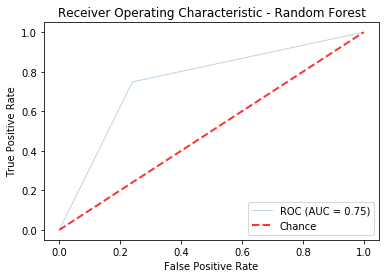

In [280]:
def plot_roc(fpr,tpr, model_name):    
    auc_score = m.auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,label='ROC (AUC = %0.2f)' % (auc_score))
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title("Receiver Operating Characteristic - " + model_name)
    plt.legend(loc="lower right")
    plt.show()

plot_roc(fpr,tpr, "Random Forest")

In [98]:
confusion_matrix(y_test,y_pred1)

array([[16743,  5167],
       [  287,   609]])

In [29]:
# checking target not contained in orignal list 
clf1_df = pd.DataFrame(y_test)
clf1_df["y_pred"] = y_pred1


# UnderSampling Techniques 

# Near Miss - UnderSampling Method

In [39]:
# Load near miss under sampling method 

from imblearn.under_sampling import NearMiss
nm1 = NearMiss(sampling_strategy="majority",version=2,n_jobs=-1)

In [237]:
# Select features 

col_list = df_info["Features"].head(30).tolist()
len(col_list)

40

In [238]:
# Cross Val Split 

X_train, X_test, y_train, y_test = ms.train_test_split(training_data[col_list], target, test_size=0.3, random_state=21,)

In [239]:
X_resampled_nm1, y_resampled = nm1.fit_resample(X_train,y_train)

In [43]:
len(X_resampled_nm1)

4224

In [44]:
y_train.value_counts()

0    51102
1     2112
Name: TARGET, dtype: int64

In [45]:
y_test.value_counts()

0    21910
1      896
Name: TARGET, dtype: int64

In [46]:
len(y_resampled)

4224

In [47]:
len(X_resampled_nm1)

4224

In [240]:
clf1.fit(X_resampled_nm1, y_resampled)

RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=50, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [241]:
y_pred_sample = clf1.predict(X_test.as_matrix())

C:\Users\farthur\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [254]:
m.roc_auc_score(y_test, y_pred_sample)

0.543715769055226

In [255]:
m.recall_score(y_test, y_pred_sample)

0.9375

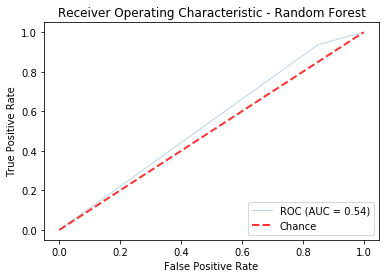

In [261]:
fpr, tpr, roc_thresholds = m.roc_curve(y_test,y_pred_sample)
plot_roc(fpr,tpr, "Random Forest")

In [252]:
confusion_matrix(y_test,y_pred_sample)

array([[ 3285, 18625],
       [   56,   840]])

# One Sided - Under Sampling Methods

In [108]:
from imblearn.under_sampling import OneSidedSelection
oss = OneSidedSelection(random_state=42, n_jobs=-1)

In [248]:
X_res, y_res = oss.fit_resample(X_train,y_train)

In [110]:
len(X_res), len(y_res)

(52436, 52436)

In [262]:
clf1.fit(X_res, y_res)

RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=50, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [263]:
m.roc_auc_score(y_test,clf1.predict(X_test))

0.7174135668644456

In [265]:
m.recall_score(y_test,clf1.predict(X_test))

0.6651785714285714

In [264]:
confusion_matrix(y_test,clf1.predict(X_test))

array([[16863,  5047],
       [  300,   596]])

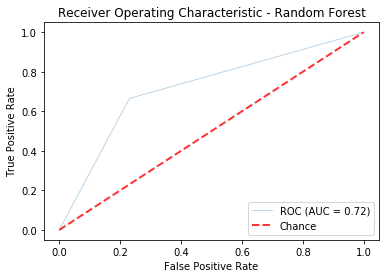

In [266]:
fpr, tpr, roc_thresholds = m.roc_curve(y_test,clf1.predict(X_test))
plot_roc(fpr,tpr, "Random Forest")

# Random Sampling - Under Sampling Method 

In [267]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X_train,y_train)

In [268]:
len(X_res) , len(y_res)

(4224, 4224)

In [269]:
clf1.fit(X_res, y_res)

RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=50, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [270]:
m.roc_auc_score(y_test,clf1.predict(X_test))

0.7240058763121862

In [272]:
m.recall_score(y_test,clf1.predict(X_test))

0.6919642857142857

In [271]:
confusion_matrix(y_test,clf1.predict(X_test))

array([[16565,  5345],
       [  276,   620]])

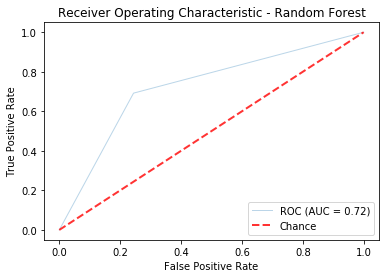

In [281]:
fpr, tpr, roc_thresholds = m.roc_curve(y_test,clf1.predict(X_test))
plot_roc(fpr,tpr, "Random Forest")

In [274]:
clf2 = xgb.XGBClassifier(n_estimators=110, nthread=-1, max_depth = 4, seed=1729, n_jobs=-1)

In [275]:
clf2.fit(X_res, y_res)
m.roc_auc_score(y_test,clf2.predict(X_test.as_matrix()))

C:\Users\farthur\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


0.7542228862391603

In [276]:
confusion_matrix(y_test,clf2.predict(X_test.as_matrix()))

C:\Users\farthur\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


array([[16642,  5268],
       [  225,   671]])

C:\Users\farthur\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


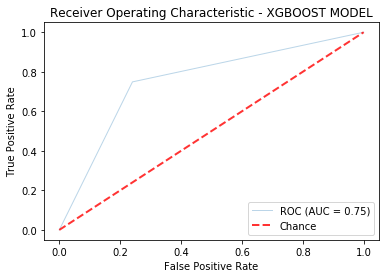

In [282]:
fpr, tpr, roc_thresholds = m.roc_curve(y_test,clf2.predict(X_test.as_matrix()))
plot_roc(fpr,tpr, "XGBOOST MODEL")

# Grid Search

In [217]:
random_forest_para_grid = {'n_estimators':[1,100]
                , 'max_depth':[1,20]
                , 'min_samples_split':[2,10]
                } 

xgb_para_grid = {'n_estimators':[1,50,100,200]                  
                ,'min_child_weight': [1, 5, 10]
                ,'gamma': [0.5, 1, 1.5, 2, 5]
                ,'subsample': [0.6, 0.8, 1.0]
                ,'colsample_bytree': [0.6, 0.8, 1.0]
                ,'max_depth': [3, 4, 5]
    
}

In [213]:
clf2

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=110, n_jobs=-1,
              nthread=-1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1729,
              silent=None, subsample=1, verbosity=1)

In [209]:
randomF_grid = ms.GridSearchCV(clf1, random_forest_para_grid,scoring="roc_auc", n_jobs=-1, return_train_score=True, verbose=1)
randomF_grid.fit(X_res, y_res)

C:\Users\farthur\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Done   9 out of  24 | elapsed:    0.5s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    3.0s finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True,
                                              class_weight='balanced_subsample',
                                              criterion='gini', max_depth=5,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=50, n_jobs=-1,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                       

In [194]:
y_test.value_counts()

0    21910
1      896
Name: TARGET, dtype: int64

In [187]:
try:
    pd.DataFrame(randomF_grid.cv_results_).to_csv("RF_grid_results_2.csv")
except:
    pass

In [210]:
RF_grid_y = randomF_grid.predict(X_test.as_matrix())
confusion_matrix(y_test,RF_grid_y)

C:\Users\farthur\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


array([[16722,  5188],
       [  239,   657]])

In [211]:
m.recall_score(y_test,RF_grid_y)

0.7332589285714286

In [212]:
m.roc_auc_score(y_test,RF_grid_y)

0.7482360366271108

In [218]:
xgb_grid = ms.GridSearchCV(clf2, xgb_para_grid,scoring="roc_auc", n_jobs=-1, return_train_score=True, verbose=1)
xgb_grid.fit(X_res, y_res)

C:\Users\farthur\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1620 candidates, totalling 4860 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   59.6s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 4860 out of 4860 | elapsed: 11.3min finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=4, min_child_weight=1,
                                     missing=None, n_estimators=110, n_jobs=-1,
                                     nthread=-1, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, r...1,
                                     scale_pos_weight=1, seed=1729, silent=None,
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=-1,
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'gamma': [0.5, 1, 1.5, 2, 5], 'max_depth': [3, 4, 5],
                         'min_c

In [219]:
XGB_grid_y = xgb_grid.predict(X_test.as_matrix())
confusion_matrix(y_test,XGB_grid_y)

C:\Users\farthur\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


array([[16747,  5163],
       [  230,   666]])

In [220]:
m.recall_score(y_test,XGB_grid_y)

0.7433035714285714

In [221]:
m.roc_auc_score(y_test,XGB_grid_y)

0.7538288738019169